In [32]:
import numpy as np
import torch
import torch.nn as nn
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.offline as py
import plotly.graph_objs as go

from sklearn.preprocessing import MinMaxScaler


In [33]:
# Config & Setup Details
cfg_batch_size  = 50
cfg_max_epochs  = 10
cfg_num_workers = 2

# Learning Config
cfg_split   = 0.8
cfg_seq_len = 180

# Data Config
cfg_data_separator = ","
cfg_data_date_fmt  = "%Y-%m-%d"
cfg_data_url_train = "https://s3.amazonaws.com/mtsu.csci.7850.project/train.csv"

# Logger Config
cfg_logger_dir     = "logs"
cfg_logger_name    = "Project"
cfg_logger_version = "data-loader"


In [34]:
# Setup CPU or GPU Device Settings for CUDA
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

Only CPU is available...


In [43]:
# Load Data - Parse the Date Column
df_raw = pd.read_csv(cfg_data_url_train, parse_dates=["date"])

print(f"Raw Shape: {df_raw.shape}")
print(df_raw.head())
print("********\n")

# Format Date Column to DateTime
df_raw['date'] = pd.to_datetime(df_raw['date'], format=cfg_data_date_fmt)

# Get Sales (Sum across all Stores) Grouped by Date
df_grouped_date = df_raw.groupby(['date'])['sales'].sum().reset_index()
print(f"Grouped by Date Shape: {df_grouped_date.shape}")
print(df_grouped_date)
print("********\n")

# Resetting the index
df_train = df_grouped_date.reset_index()

# Show the New Table
print(f"Training Shape: {df_train.shape}")
print(df_train)
print(f"Training Cols: {df_train.columns}")
print("********\n")



Raw Shape: (913000, 4)
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
********

Grouped by Date Shape: (1826, 2)
           date  sales
0    2013-01-01  13696
1    2013-01-02  13678
2    2013-01-03  14488
3    2013-01-04  15677
4    2013-01-05  16237
...         ...    ...
1821 2017-12-27  20378
1822 2017-12-28  21885
1823 2017-12-29  23535
1824 2017-12-30  24988
1825 2017-12-31  26420

[1826 rows x 2 columns]
********

Training Shape: (1826, 3)
      index       date  sales
0         0 2013-01-01  13696
1         1 2013-01-02  13678
2         2 2013-01-03  14488
3         3 2013-01-04  15677
4         4 2013-01-05  16237
...     ...        ...    ...
1821   1821 2017-12-27  20378
1822   1822 2017-12-28  21885
1823   1823 2017-12-29  23535
1824   1824 2017-12-30  24988
1825   1825 2017-12-31  26420

[1826 rows x 3 columns]
Training Cols:

In [44]:
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
sales_data = df_train['sales'].values.reshape(-1, 1)
scaled_sales_data = scaler.fit_transform(sales_data)
df_train['sales'] = scaled_sales_data


df_avg = df_train

# Set the Roling Average of the last 7 days
df_avg['sales'] = df_avg['sales'].rolling(window=7, min_periods=1).mean()

# Displaying the updated DataFrame with moving averages
df_avg.head(10) 

,index,date,sales
0,0,2013-01-01,0.059801
1,1,2013-01-02,0.059530
2,2,2013-01-03,0.067566
3,3,2013-01-04,0.080529
4,4,2013-01-05,0.091678
5,5,2013-01-06,0.104398
6,6,2013-01-07,0.089742
7,7,2013-01-08,0.089157
8,8,2013-01-09,0.090017
9,9,2013-01-10,0.090679


In [45]:
# Setup the Dataframe being used
df = df_avg # Simple Copy
df.set_index('date', inplace=True)
print(f"DF Shape: {df.shape}")

df.head(10) 

DF Shape: (1826, 2)


,index,sales
date,,
2013-01-01,0,0.059801
2013-01-02,1,0.059530
2013-01-03,2,0.067566
2013-01-04,3,0.080529
2013-01-05,4,0.091678
2013-01-06,5,0.104398
2013-01-07,6,0.089742
2013-01-08,7,0.089157
2013-01-09,8,0.090017


In [46]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)]['sales'].values
        y = data.iloc[i + seq_length]['sales']
        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)

In [48]:
x, y = create_sequences(df, cfg_seq_len)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split the data into training and testing sets
train_size = int(cfg_split * len(x_tensor))

x_train = x_tensor[:train_size]
#x_train = x_train.unsqueeze(-1)

y_train = y_tensor[:train_size]

x_val = x_tensor[train_size:]
y_val = y_tensor[train_size:]

In [49]:
print(f"x Shape: {x.shape}")
print(f"y Shape: {y.shape}")
print("")
print(f"x_train Shape: {x_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print("")
print(f"x_val Shape: {x_val.shape}")
print(f"y_val Shape: {y_val.shape}")

x Shape: (1646, 180)
y Shape: (1646,)

x_train Shape: torch.Size([1316, 180])
y_train Shape: torch.Size([1316])

x_val Shape: torch.Size([330, 180])
y_val Shape: torch.Size([330])


In [50]:
class LSTMModel(pl.LightningModule):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size, 
                 num_layers,
                 scaler = 10000,
                 **kwargs):
        super().__init__(**kwargs)

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1)
        self.dropout = torch.nn.Dropout1d(0.1) # Whole token dropped
        self.linear = nn.Linear(hidden_size, output_size)
        self.loss = nn.MSELoss()
        self.scaler = scaler

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer

    # No complications with regression...
    def predict(self, x):
        return self(x)
    
    def forward(self, x):
        x = x.unsqueeze(-1)
        y = x
        #y = y / self.scaler
        #y = torch.log(y)
        y, _ = self.lstm(y)
        y = y[:, -1, :] # Extract only the last time step
        y = self.linear(y) # Using linear to bring back to output_size
        #y = torch.exp(y)
        #y * self.scaler
        
        return y

    def training_step(self, train_batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        x, y_true = train_batch
        y_pred = self(x)
        loss = self.loss(y_pred, y_true)
        self.log('train_loss', loss, on_step=False, on_epoch=True)

        offset = y_true.sum() - y_pred.sum()
        self.log('train_offset', offset, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        loss = self.loss(y_pred, y_true)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        offset = y_true.sum() - y_pred.sum()
        self.log('val_offset', offset, on_step=False, on_epoch=True)
        
        return loss


# Model parameters
input_size  = 1  # Number of features (sales data from 10 stores)
hidden_size = 50 # Number of features in hidden state
output_size = 1  # Number of output values (future sales prediction)
num_layers  = 4  # Number of stacked LSTM layers

# Create the LSTM model
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

In [51]:
summary(model, input_data=torch.Tensor(x_train[0:5]).float())

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [5, 1]                    --
├─LSTM: 1-1                              [5, 180, 50]              71,800
├─Linear: 1-2                            [5, 1]                    51
Total params: 71,851
Trainable params: 71,851
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 64.62
Input size (MB): 1.19
Forward/backward pass size (MB): 0.36
Params size (MB): 0.29
Estimated Total Size (MB): 1.83

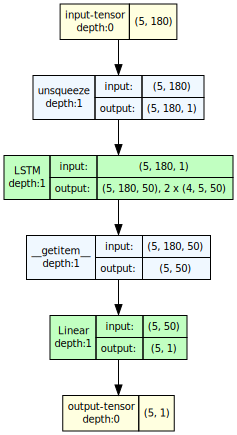

In [52]:
model_graph = draw_graph(model,
                         input_data=torch.Tensor(x_train[0:5]).float(),
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False,
                         depth=3,
                         dtypes=[torch.long])

model_graph.visual_graph

In [53]:
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_train).float(),
                                                torch.Tensor(y_train).float())), 
                                       shuffle=True, 
                                       batch_size=cfg_batch_size, 
                                       num_workers=cfg_num_workers)

xy_val = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_val).float(), 
                                              torch.Tensor(y_val).float())), 
                                     shuffle=False, 
                                     batch_size=cfg_batch_size, 
                                     num_workers=cfg_num_workers)

In [54]:
logger = pl.loggers.CSVLogger("lightning_logs", 
                              name="Project",
                              version="1.0.0")

In [55]:
trainer = pl.Trainer(logger=logger, max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False, 
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [56]:
trainer.validate(model, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning:

Experiment logs directory lightning_logs/Project/1.0.0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning:

Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning:

Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.18379387259483337    │
│        val_offset         │    19.959238052368164     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.18379387259483337, 'val_offset': 19.959238052368164}]

In [57]:
trainer.fit(model, xy_train, xy_val) 


  | Name    | Type      | Params
--------------------------------------
0 | lstm    | LSTM      | 71.8 K
1 | dropout | Dropout1d | 0     
2 | linear  | Linear    | 51    
3 | loss    | MSELoss   | 0     
--------------------------------------
71.9 K    Trainable params
0         Non-trainable params
71.9 K    Total params
0.287     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning:

Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [58]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_loss,val_offset,epoch,step,train_loss,train_offset
0,0.183794,19.959238,0,0,NaN,NaN
1,0.132988,16.665829,0,26,NaN,NaN
2,NaN,NaN,0,26,0.079154,11.782166
3,0.078883,12.193293,1,53,NaN,NaN
4,NaN,NaN,1,53,0.048871,7.961207
5,0.033329,6.227253,2,80,NaN,NaN
6,NaN,NaN,2,80,0.026117,2.443260
7,0.037573,7.006591,3,107,NaN,NaN
8,NaN,NaN,3,107,0.022892,-0.485680
9,0.035756,6.682762,4,134,NaN,NaN


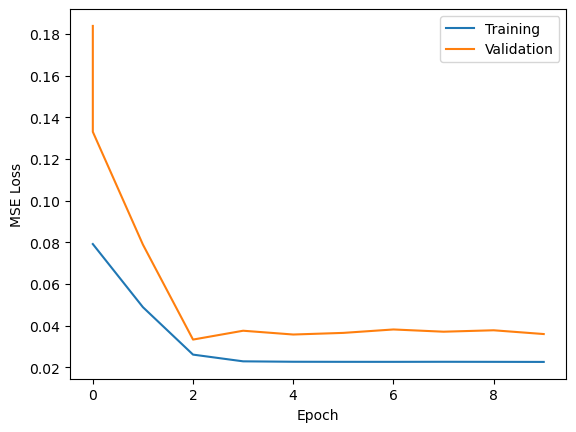

In [59]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))], 
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))], 
         label="Validation")

plt.legend() 
plt.ylabel("MSE Loss") 
plt.xlabel("Epoch") 
plt.show()

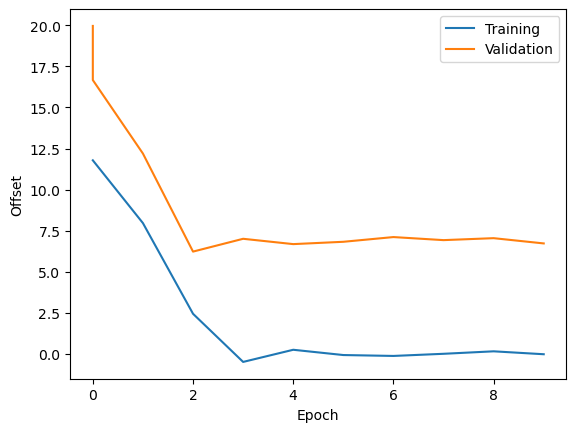

In [60]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_offset"]))],
         results["train_offset"][np.logical_not(np.isnan(results["train_offset"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_offset"]))], 
         results["val_offset"][np.logical_not(np.isnan(results["val_offset"]))], 
         label="Validation")

plt.legend() 
plt.ylabel("Offset") 
plt.xlabel("Epoch") 
plt.show()

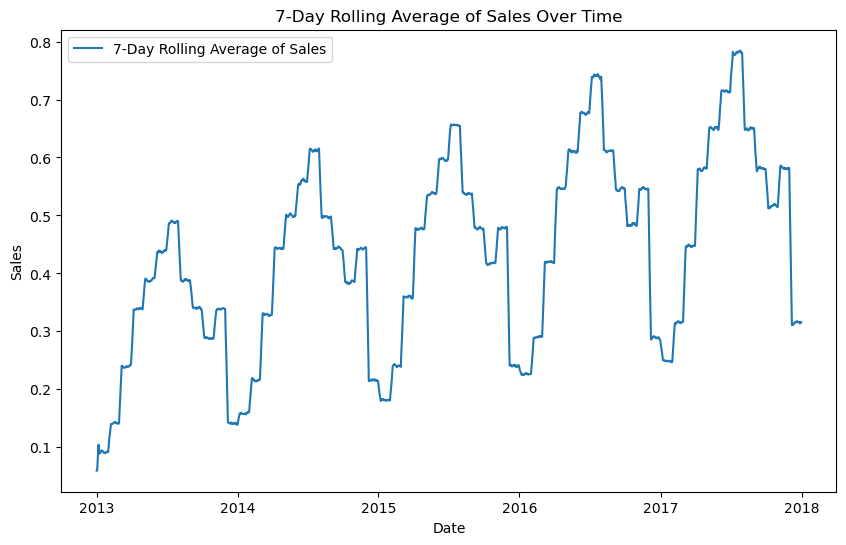

In [67]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(df['sales'], label='7-Day Rolling Average of Sales')  # Plot the sales data
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Sales')  # Label for the y-axis
plt.title('7-Day Rolling Average of Sales Over Time')  # Title of the plot
plt.legend()  # Add a legend
plt.show() 

In [99]:

last_50_sales = df_avg['sales'][-180:-90]
sales_array = last_50_sales.values
sales_array_reshaped = sales_array.reshape(1, -1)
print(sales_array_reshaped.shape)


tensor_input = torch.tensor(sales_array_reshaped, dtype=torch.float32)
print(tensor_input.shape)
pred = model.predict(tensor_input)
pred = pred.detach().numpy()

print(pred)

print(last_50_sales[:].values)


(1, 90)
torch.Size([1, 90])
[[0.44201216]]
[0.76208247 0.7701869  0.78225539 0.77823543 0.77683381 0.77661024
 0.77752172 0.77813224 0.77732825 0.77791297 0.78010998 0.78116764
 0.7821823  0.78074629 0.7814557  0.78253056 0.78121493 0.78268964
 0.78258215 0.7829347  0.78420304 0.78416004 0.78414284 0.78186845
 0.78014008 0.78014437 0.7806732  0.76268009 0.74466118 0.72560611
 0.70773768 0.68678226 0.66297632 0.64779504 0.64823788 0.64794552
 0.64918375 0.64896878 0.64966959 0.65051658 0.64841416 0.64697385
 0.64698245 0.64673738 0.64740809 0.6480702  0.6503489  0.65053807
 0.65229654 0.6518838  0.65138936 0.64985876 0.65071435 0.6495879
 0.65117439 0.65062836 0.65048218 0.65047788 0.64035273 0.6276952
 0.61376935 0.60546286 0.59477447 0.58607673 0.57623103 0.57893538
 0.57840655 0.58116248 0.58124847 0.58231473 0.58347127 0.58428816
 0.58185039 0.58293384 0.58153223 0.58123127 0.58136885 0.58200517
 0.58136025 0.58189768 0.58067664 0.57972647 0.58067664 0.58053906
 0.58084432 0.5801908

In [ ]:
for i in range(30):
    tensor_input = torch.tensor(data_pred, dtype=torch.float32).unsqueeze(0)
    pred = model.predict(tensor_input)
    pred = pred.detach().numpy()
    data_pred = np.append(data_pred[1:], pred.reshape(1, -1), axis=0)

In [ ]:
data_set_summed = data_set.sum(axis=1)
data_set_pred = data_pred.sum(axis=1)


# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(data_set_summed)
plt.plot(data_set_pred)
plt.title('Plot without Explicit Index')
plt.show()